In [108]:
import os
import cv2
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import table
from astropy.stats import sigma_clipped_stats

### This section contains the functions that are called in later by additional functions.

In [86]:
def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours,hierarchy = cv2.findContours(img_bin,
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)

    return contours, hierarchy

In [87]:
def get_ellipse_leastsq(contour, image):
    """
    Fits an ellipse to a (single) contour and returns the sum of the
    differences squared between the fitted ellipse and contour (normalised).

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.

    Returns
    -------
    float
        sum((ellipse-contour)^2)/number_of_pixels
    """
    thickness = -1
    y_npix = image.shape[0]
    x_npix = image.shape[1]

    contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
    cv2.drawContours(contour_arr, [contour], 0, (1, 1, 1), thickness)

    ellipse_arr, params = fit_ellipse(contour, image, return_params=True)

    if np.any(np.isnan(params)):
        res = np.nan
    else:
        arr_diff = ellipse_arr - contour_arr
        res = np.sum((arr_diff)**2) / np.prod(contour_arr.shape)

    return [res] + list(params)

In [104]:
def fit_ellipse(contour, image, return_params=False):
    """
    Fits an ellipse to a contour and returns a binary image representation of
    the ellipse.

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    return_params : bool
        If true also returns the parameters of the fitted ellipse

    Returns
    -------
    np.ndarray
        2d binary image with representation of the ellipse
    """

    thickness = 2
    y_npix = image.shape[0]
    x_npix = image.shape[1]
    ellipse_arr = np.zeros([y_npix, x_npix], dtype=np.float)

    # Sets some defaults for when the fitting fails
    default_return_params = [np.nan] * 5 
    raised_error = False

    try:
        ((x0, y0), (maj_axis, min_axis), theta) = cv2.fitEllipse(contour)
        ellipse_params = x0, y0, maj_axis, min_axis, theta

        if np.any(np.isnan(ellipse_params)):
            raised_error = True
            logging_tools.log('fit_ellipse failed with unknown error:')

    except cv2.error as e:
        logging_tools.log('fit_ellipse failed with cv2 error:' + e.msg)
        raised_error = True

    if raised_error:
        if return_params:
            return ellipse_arr, default_return_params
        else:
            return ellipse_arr

    x0 = int(np.round(x0))
    y0 = int(np.round(y0))
    maj_axis = int(np.round(maj_axis))
    min_axis = int(np.round(min_axis))
    theta = int(np.round(theta))

    cv2.ellipse(ellipse_arr, (x0, y0), (maj_axis // 2, min_axis // 2), 
                theta, 0, 360, (1, 1, 1), thickness)

    if return_params:
        return ellipse_arr, ellipse_params
    else:
        return ellipse_arr

________________________

# Creating The Catalogue

The tractor catalogue files downloaded from the server have to be adjusted in order for Astronomaly to be able to use it. This section reads in a downloaded tractor file along with the corresponding image files and prepares them for Astronomaly to use. 

In [88]:
catalogue_file = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Catalogue/tractor-0260m062.fits'

In [89]:
image_file_g = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/g-legacysurvey-0260m062-image.fits.fz'
image_file_r = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/r-legacysurvey-0260m062-image.fits.fz'
image_file_z = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/z-legacysurvey-0260m062-image.fits.fz'

________________

### This is the function that creates a new catalogue ready for use with Astronomaly.
### NOTE: Point sources are removed here.

In [90]:
def convert_tractor_catalogue(catalogue_file, image_file, image_name=''):
    """
    Converts a tractor fits file to a pandas dataframe to be given
    directly to an ImageDataset object.

    Parameters
    ----------
    catalogue_files : string
        tractor catalogue in fits table format 
    image_file:
        The image corresponding to this catalogue (to extract pixel information
        and naming information)
    """

    catalogue = astropy.table.Table(astropy.io.fits.getdata(catalogue_file,ignore_missing_end=True))

    dataframe = {}
    for name in catalogue.colnames:
        data = catalogue[name].tolist()
        dataframe[name] = data
    
    old_catalogue = pd.DataFrame(dataframe)
    hdul = astropy.io.fits.open(image_file)

    if len(image_name) == 0:
        original_image_ = image_file_g.split(os.path.sep)[-1]
        original_image = original_image_.replace(original_image_[:2],'')
    else:
        original_image = image_name
    
    #w = astropy.wcs.WCS(hdul[0].header, naxis=2)
    #x, y = w.wcs_world2pix(old_catalogue['ra'], old_catalogue['dec'], 1)
    
    new_catalogue = pd.DataFrame()
    new_catalogue['objid'] = old_catalogue['objid']
    new_catalogue['original_image'] = [original_image] * len(new_catalogue)
    new_catalogue['flux_g'] = old_catalogue['flux_g']
    new_catalogue['flux_r'] = old_catalogue['flux_r']
    new_catalogue['flux_z'] = old_catalogue['flux_z']
    new_catalogue['x'] = old_catalogue['bx'].astype('int')
    new_catalogue['y'] = old_catalogue['by'].astype('int')
    new_catalogue['ra'] = old_catalogue['ra']
    new_catalogue['dec'] = old_catalogue['dec']
    new_catalogue['type'] = old_catalogue['type']
    
    ## Removes PSFs
    catalogue_no_PSFs = new_catalogue[new_catalogue.type.astype("S") != b'PSF ']
    
    return new_catalogue

#### The new catalogue is created using the following method:

In [91]:
catalogue = convert_tractor_catalogue(catalogue_file, image_file_g)

______________________

# Image Transformation

The images are transformed using the following functions. Combined they form the entire image transform function for the DECaLS dataset. It should be noted that the images transformed here are the cutouts of the objects contained within the datasets and are not the same as the images in the previous section.

In [92]:
image = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.0835_-6.3682.fits'

In [93]:
image_data = fits.getdata(image)

In [94]:
image_data_g = image_data[0]
image_data_r = image_data[1]
image_data_z = image_data[2]

____________

### Sigma Clipping

In [95]:
def image_transform_sigma_clipping(img, sigma=3, central=True):
    """
    Applies sigma clipping, fits contours and

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray

    """
    if len(img.shape) > 2:
        im = img[:, :, 0]
    else:
        im = img

    im = np.nan_to_num(im)  # OpenCV can't handle NaNs

    mean, median, std = sigma_clipped_stats(im, sigma=sigma)
    thresh = std + median
    img_bin = np.zeros(im.shape, dtype=np.uint8)

    img_bin[im <= thresh] = 0
    img_bin[im > thresh] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2

    for c in contours:
        if cv2.pointPolygonTest(c, (x0, y0), False) == 1:
            break

    contour_mask = np.zeros_like(img, dtype=np.uint8)
    if len(contours) == 0:
        # This happens if there's no data in the image so we just return zeros
        return contour_mask
    cv2.drawContours(contour_mask, [c], 0, (1, 1, 1), -1)

    new_img = np.zeros_like(img)
    new_img[contour_mask == 1] = img[contour_mask == 1]

    return new_img

#### Results from the Sigma Clipping

In [96]:
img = image_transform_sigma_clipping(image_data_g)

<function matplotlib.pyplot.show(close=None, block=None)>

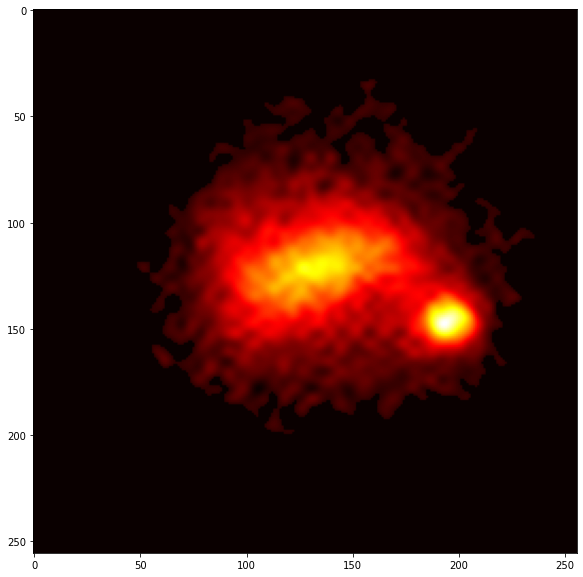

In [97]:
plt.figure(figsize = (10,10))
plt.imshow(img, cmap = 'hot')
plt.show

### Scale Transform (Normalises the values)

In [98]:
def image_transform_scale(img):
    """
    Small function to normalise an image between 0 and 1. Useful for deep 
    learning.

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray
        Scaled image

    """
    if img.min() == img.max():
        return img
    return (img - img.min()) / (img.max() - img.min())

#### Results from the Scale Transform

In [99]:
norm_img = image_transform_scale(img)

<function matplotlib.pyplot.show(close=None, block=None)>

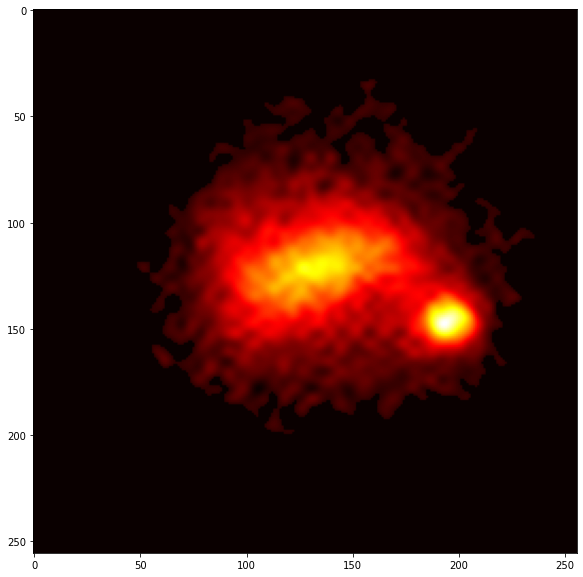

In [100]:
plt.figure(figsize = (10,10))
plt.imshow(norm_img, cmap = 'hot')
plt.show

_______________

# This is the function that creates the contours and ellipses that is used by Astronomaly. The parameters of the ellipses are also returned.

In [101]:
def contours_and_ellipses(image, percentiles):

    #image = this_image
    
    x0 = y0 = -1
    x_cent = image.shape[0] // 2
    y_cent = image.shape[1] // 2
    
    feats = []
    # Start with the closest in contour (highest percentile)
    percentiles = np.sort(percentiles)[::-1] 

    if np.all(image == 0):
        failed = True
        failure_message = "Invalid cutout for feature extraction"
    else:
        failed = False
        failure_message = ""

    for p in percentiles:
        if failed:
            contours = []
        else:
            thresh = np.percentile(image[image > 0], p)
            contours, hierarchy = find_contours(image, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))
        
            if len(contours[0]) != 0:
                for k in range(len(contours)):
                    M = cv2.moments(contours[k])
                    try:
                        x_contours[k] = int(M["m10"] / M["m00"])
                        y_contours[k] = int(M["m01"] / M["m00"])
                    except ZeroDivisionError:
                        pass
                if x0 == -1:
                    x_diff = x_contours - x_cent
                    y_diff = y_contours - y_cent
                else:
                    x_diff = x_contours - x0
                    y_diff = y_contours - y0
                
                # Will try to find the CLOSEST contour to the central one
                r_diff = np.sqrt(x_diff**2 + y_diff**2)

                ind = np.argmin(r_diff)

                if x0 == -1:
                    x0 = x_contours[ind]
                    y0 = y_contours[ind]

                c = contours[ind]
                
           ######### Added ALL of this to test for differences
        
                params = get_ellipse_leastsq(c, image)
                # Params return in this order:
                # residual, x0, y0, maj_axis, min_axis, theta
                if np.any(np.isnan(params)):
                    failed = True
                else:
                    if params[3] == 0 or params[4] == 0:
                        aspect = 1
                    else:
                        aspect = params[4] / params[3]

                    if aspect < 1:
                        aspect = 1 / aspect
                    if aspect > 100:
                        aspect = 1                
                
                    new_params = params[:3] + [aspect] + [params[-1]]
                    feats.append(new_params)
            else:
                failed = True
                failure_message = "No contour found"

            if failed:
                feats.append([np.nan] * 5)
                logging_tools.log(failure_message)
            
        # Now we have the leastsq value, x0, y0, aspect_ratio, theta for each 
        # sigma
        # Normalise things relative to the highest threshold value
        # If there were problems with any sigma levels, set all values to NaNs
        if np.any(np.isnan(feats)):
            return [np.nan] * 4 * len(percentiles)
        else:
            max_ind = np.argmax(percentiles)

            residuals = []
            dist_to_centre = []
            aspect = []
            theta = []

            x0_max_sigma = feats[max_ind][1]
            y0_max_sigma = feats[max_ind][2]
            aspect_max_sigma = feats[max_ind][3]
            theta_max_sigma = feats[max_ind][4]

            for n in range(len(feats)):
                prms = feats[n]
                residuals.append(prms[0])
                if prms[1] == 0 or prms[2] == 0:
                    r = 0
                else:
                    x_diff = prms[1] - x0_max_sigma
                    y_diff = prms[2] - y0_max_sigma
                    r = np.sqrt((x_diff)**2 + (y_diff)**2)
                dist_to_centre.append(r)
                aspect.append(prms[3] / aspect_max_sigma)
                theta_diff = np.abs(prms[4] - theta_max_sigma) % 360
                # Because there's redundancy about which way an ellipse 
                # is aligned, we always take the acute angle
                if theta_diff > 90:
                    theta_diff -= 90
                theta.append(theta_diff)

            normalized_parameters = np.hstack((residuals, dist_to_centre, aspect, theta))
            
            #########
            
        thickness = 2
            
        y_npix = image.shape[0]
        x_npix = image.shape[1]
            
        contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
            
        arr = image.copy()
            
        cnt = cv2.drawContours(arr, [c], 0, (0.9, 0, 0), thickness)
            
        ellipse_arr, params = fit_ellipse(c, image, return_params=True)

        print('Percentile is :' ,p)
        print( 'Parameters are :' ,params)
        #print(normalized_parameters)
            
            # Display the contours and ellipses
        f = plt.figure(figsize = (15,15))
            
        f.add_subplot(1,2, 1)
        #plt.imshow(image, cmap='gray')
        plt.imshow(cnt, cmap='hot')

        f.add_subplot(1,2, 2)
        plt.imshow(ellipse_arr, cmap='hot')
            
        plt.show(block=True)

______________

#### The function requires percentiles to be given which are used to separate the images into regions of different flux levels.

In [106]:
percentiles = [90,80,70,60,50,0]

## Applying the function to obtain the contours and ellipses

Percentile is : 90
Parameters are : (132.89987182617188, 121.1827163696289, 28.409435272216797, 65.16228485107422, 71.17584228515625)


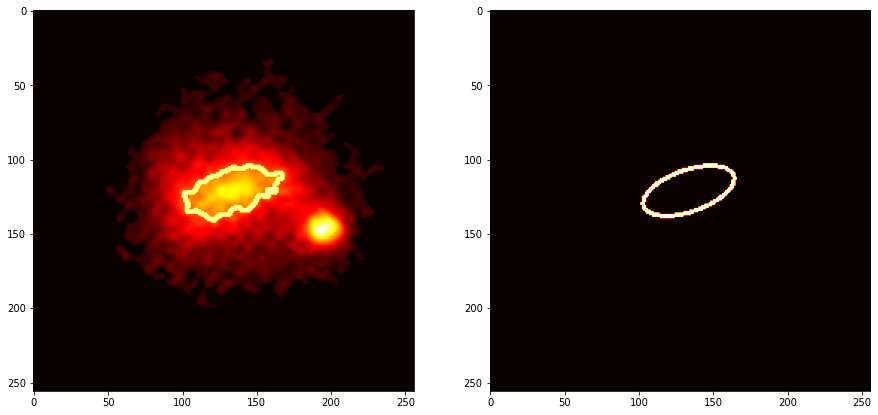

Percentile is : 80
Parameters are : (143.65310668945312, 127.58811950683594, 54.77203369140625, 109.69129943847656, 104.58352661132812)


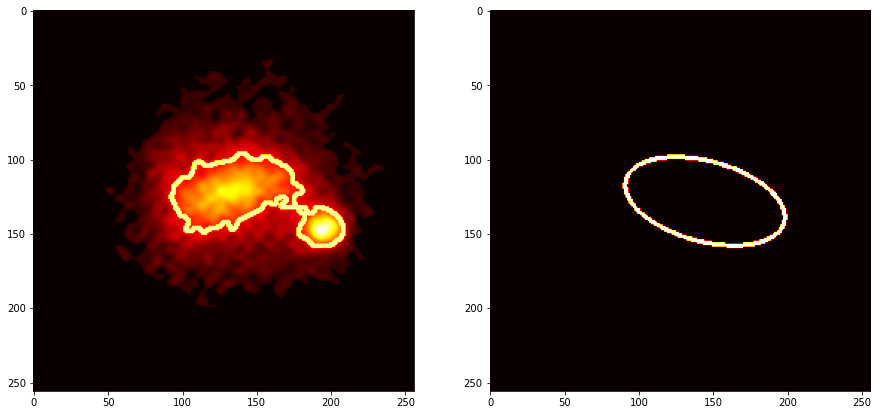

Percentile is : 70
Parameters are : (141.76968383789062, 126.94242095947266, 66.60992431640625, 123.26805877685547, 97.46232604980469)


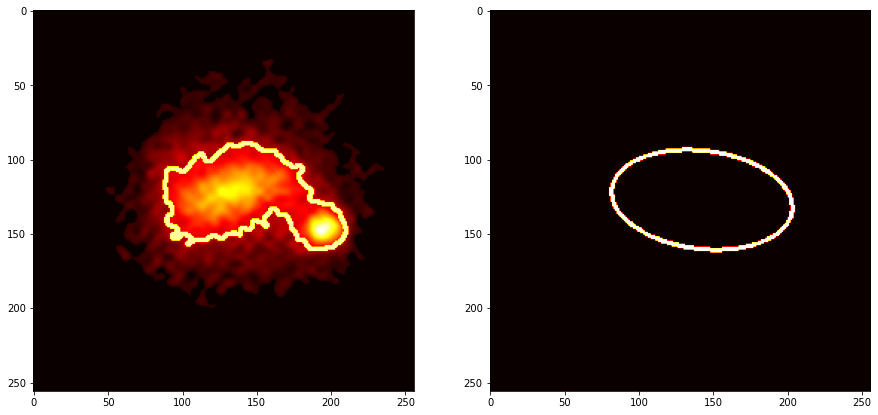

Percentile is : 60
Parameters are : (142.2775115966797, 125.21504974365234, 75.50382232666016, 134.269287109375, 98.4675064086914)


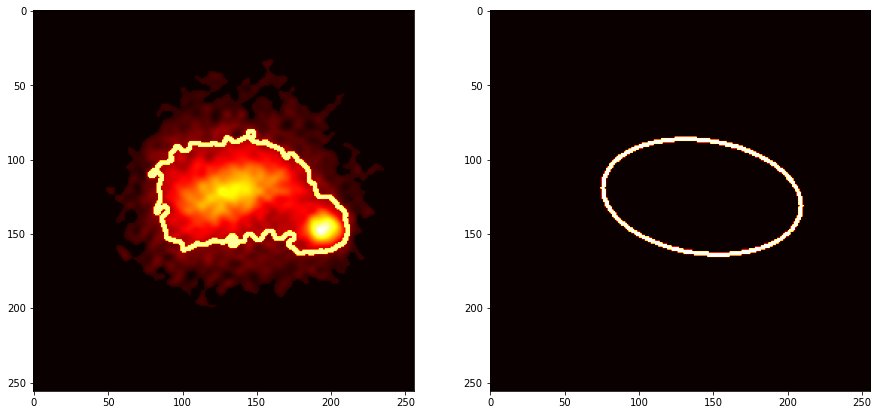

Percentile is : 50
Parameters are : (139.16285705566406, 125.12935638427734, 86.76856994628906, 141.84385681152344, 98.05183410644531)


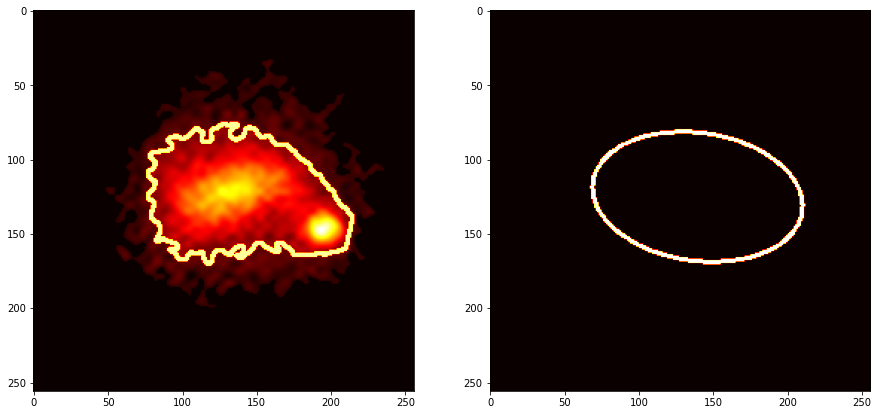

Percentile is : 0
Parameters are : (140.46800231933594, 122.10108947753906, 146.7713623046875, 166.46469116210938, 87.72015380859375)


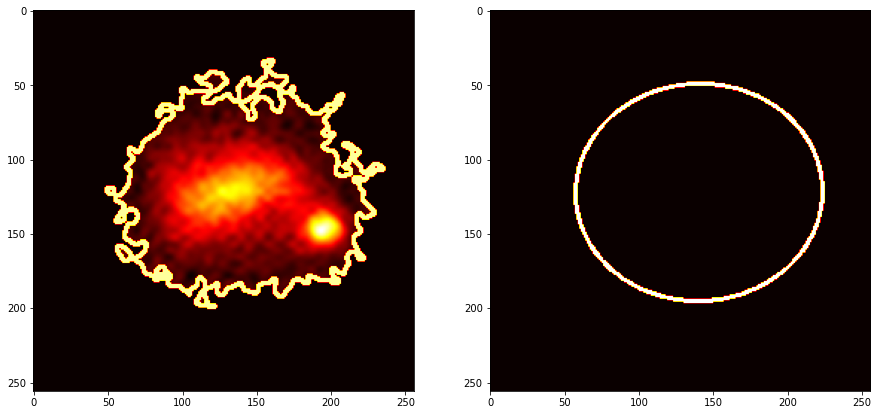

In [107]:
contours_and_ellipses(norm_img, percentiles)